In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.special import gamma
import sys
import emcee
plt.rcParams['font.size']=20

<Container object of 3 artists>

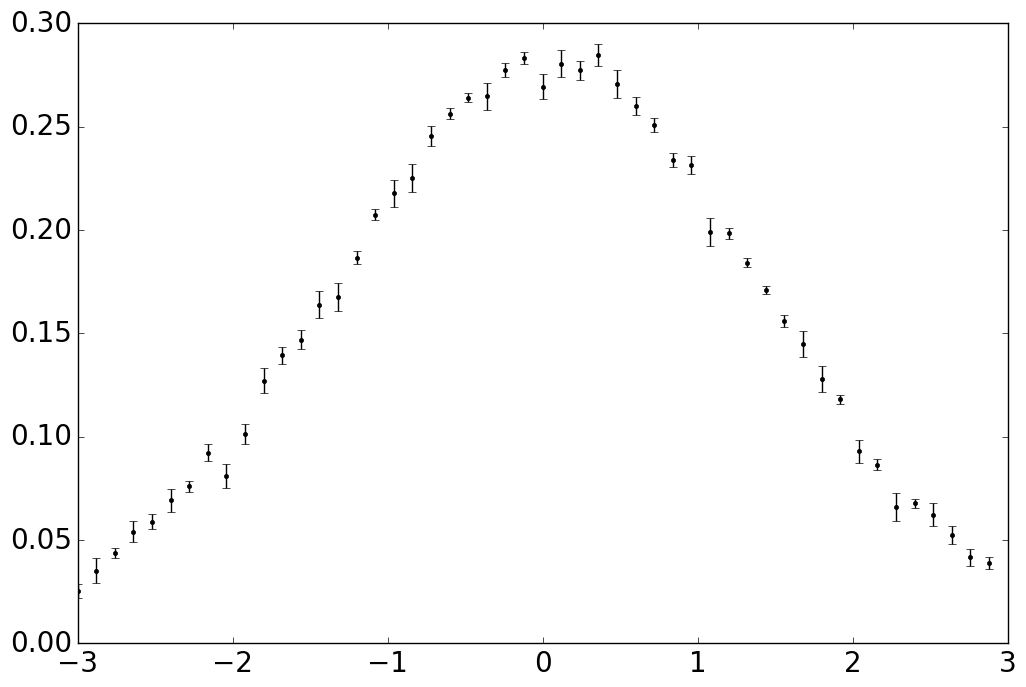

In [3]:

# Generate synthetic data from a model.
# For simplicity, let us assume a LINEAR model y = m*x + b
# where we want to fit m and b
m_true = 0.02
sigma_true = 2.

def myGaussian(x,mu,v0):
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
gauss = np.vectorize(myGaussian)

N = 50


#x = np.sort(10*np.random.rand(N))
x = np.arange(-3,3,6./N)
params = [[m_true,sigma_true] for i in x]
y = gauss(x,m_true, sigma_true)

yerr = 0.002 + 0.005*np.random.rand(len(x))
#y = m_true*x + sigma_true
y += yerr * np.random.randn(len(x))

fig = plt.figure()
fig.set_size_inches(12, 8)
plt.errorbar(x, y, yerr=yerr, fmt='.k')


In [4]:

# Now, let's setup some parameters that define the MCMC
ndim = 2
nwalkers = 500

# Initialize the chain
# Choice 1: chain uniformly distributed in the range of the parameters
pos_min = np.array([-5., 0.])
pos_max = np.array([5., 10.])
psize = pos_max - pos_min
pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

# Visualize the initialization

In [5]:
# Define the posterior PDF
# Reminder: post_pdf(theta, data) = likelihood(data, theta) * prior_pdf(theta)
# We take the logarithm since emcee needs it.

# As prior, we assume an 'uniform' prior (i.e. constant prob. density)
def lnprior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

# As likelihood, we assume the chi-square. Note: we do not even need to normalize it.
def lnlike(theta, x, y, yerr):
    mu, v0 = theta
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    model = (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
    
    #model = m * x + b
    return -0.05*(np.sum( ((y-model)/yerr)**2. ))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [6]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                lnprob, args=(x, y, yerr))

In [7]:
import time
time0 = time.time()
# burnin phase
pos, prob, state  = sampler.run_mcmc(pos, 300)
sampler.reset()
time1=time.time()
print time1-time0

/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


2.1812889576


In [8]:
import time
time0 = time.time()
# perform MCMC
pos, prob, state  = sampler.run_mcmc(pos, 700)
time1=time.time()
print time1-time0

samples = sampler.flatchain
samples.shape

4.79544210434


(350000, 2)

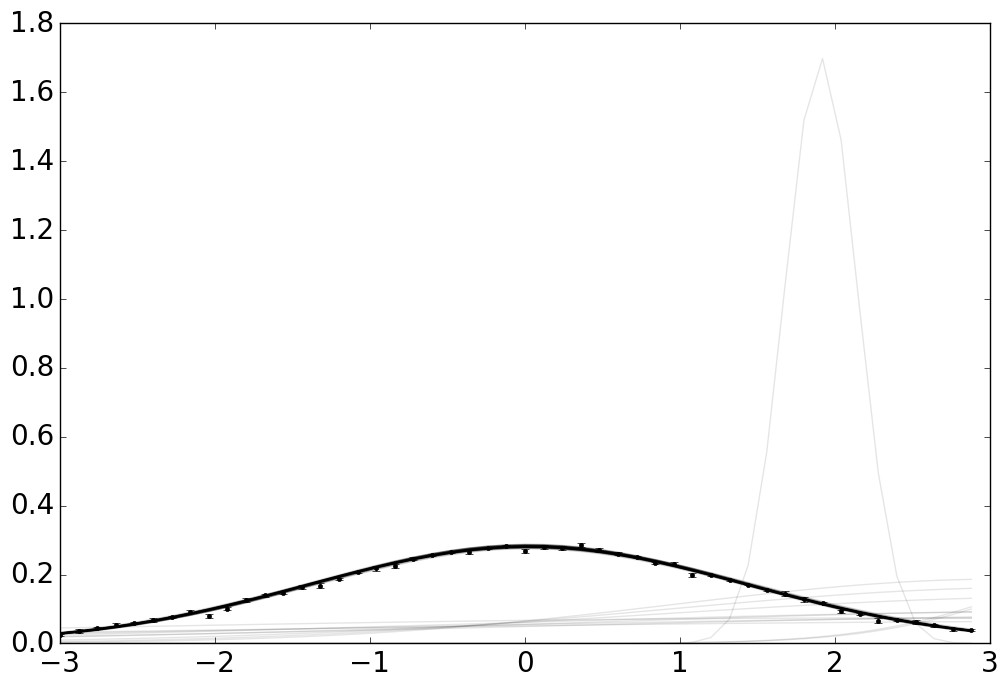

In [9]:

# Plot back the results in the space of data
fig = plt.figure()

xl = np.array([0, 10])
for m, b in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(x,gauss(x,m,b), color="k", alpha=0.1)
#plt.plot(x, gauss(x,m_true,sigma_true), color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
fig.set_size_inches(12, 8)

In [46]:
N = 50


nugauss = np.vectorize(myGaussian)

sam=samples[-100:]


mu = sam[0::2]
sigma = sam[1::2]
expected = np.array([gauss(x,i[0],i[1]) for i in sam ])
observed = np.array([y for i in sam])
chi_tmp = ((observed-expected)**2)/expected
chi2 = [np.sum(i) for i in chi_tmp]
print sam[np.where(chi2==np.min(chi2))[0][0]]




[ 0.49541826  0.91052173]


In [54]:
def bestfit(func,x,y):
    yerr = 0.002 + 0.005*np.random.rand(len(x))
    # Now, let's setup some parameters that define the MCMC
    ndim = 2
    nwalkers = 500

    # Initialize the chain
    # Choice 1: chain uniformly distributed in the range of the parameters
    pos_min = np.array([-5., 0.])
    pos_max = np.array([5., 10.])
    psize = pos_max - pos_min
    pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

    # As prior, we assume an 'uniform' prior (i.e. constant prob. density)
    def lnprior(theta):
        m, b = theta
        if -1.0 < m < 0.5 and 0.0 < b < 10.0:
            return 0.0
        return -np.inf

    # As likelihood, we assume the chi-square. Note: we do not even need to normalize it.
    def lnlike(theta, x, y, yerr):
        mu, v0 = theta
        alpha = 1.
        #n = 2 * v0 * gamma(1+(1/(2*alpha)))
        #model = (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
        model = func(x,mu,v0)
        return -0.05*(np.sum( ((y-model)/yerr)**2. ))

    def lnprob(theta, x, y, yerr):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta, x, y, yerr)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                lnprob, args=(x, y, yerr))
    pos, prob, state  = sampler.run_mcmc(pos, 1000)
    samples = sampler.flatchain
    samples.shape
    sam=samples[-100:]
    mu = sam[0::2]
    sigma = sam[1::2]
    expected = np.array([func(x,i[0],i[1]) for i in sam ])
    observed = np.array([y for i in sam])
    chi_tmp = ((observed-expected)**2)/expected
    chi2 = [np.sum(i) for i in chi_tmp]
    params = sam[np.where(chi2==np.min(chi2))[0][0]]
    return params, np.min(chi2)

In [ ]:
def myGaussian(x,params):
    mu,v0 = params[0],params[1]
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

In [31]:
params,chi2 = bestfit(myGaussian,x,y)



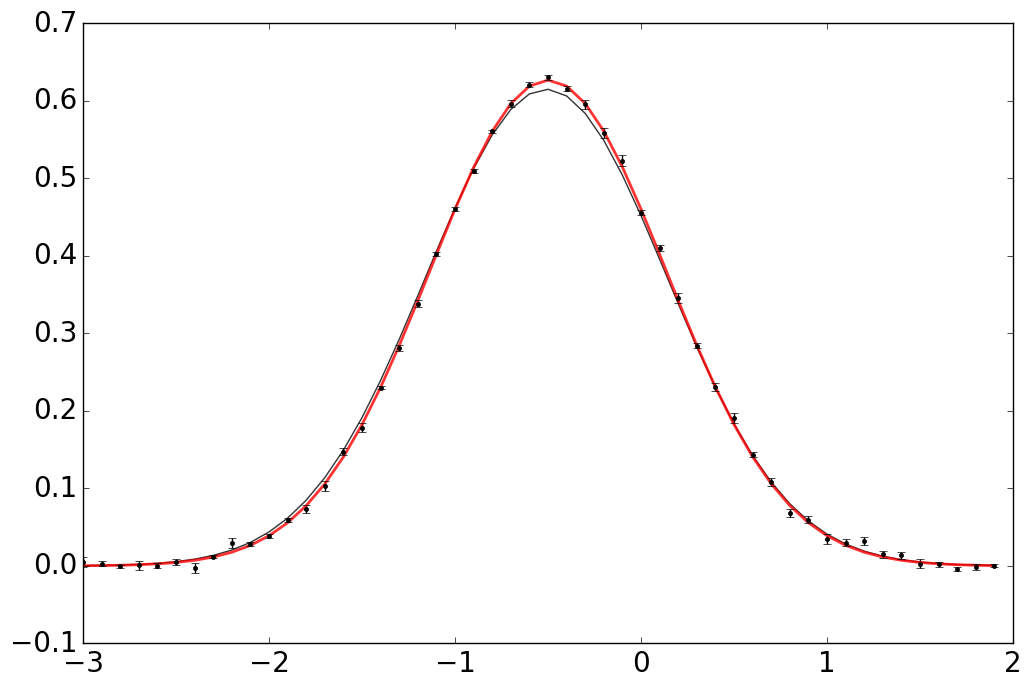

In [32]:
fig, ax =  plt.subplots()
ax.plot(x,myGaussian(x,params[0],params[1]), color="k", alpha=0.8)
ax.plot(x, gauss(x,m_true,sigma_true), color="r", lw=2, alpha=0.8)
ax.errorbar(x, y, yerr=yerr, fmt=".k")
fig.set_size_inches(12, 8)

In [76]:
def bestfit_4(func,x,y):
    yerr = 0.002 + 0.005*np.random.rand(len(x))
    # Now, let's setup some parameters that define the MCMC
    ndim = 4
    nwalkers = 500

    # Initialize the chain
    # Choice 1: chain uniformly distributed in the range of the parameters
    pos_min = np.array([0.0, 0.,.0,.0])
    pos_max = np.array([1., 10.,10,10])
    psize = pos_max - pos_min
    pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

    # As prior, we assume an 'uniform' prior (i.e. constant prob. density)
    def lnprior(theta):
        f,v,m, v2 = theta
        if -1.0 < m < 1.5 and 0.0 < f < 1.0:
            return 0.0
        return -np.inf

    # As likelihood, we assume the chi-square. Note: we do not even need to normalize it.
    def lnlike(theta, x, y, yerr):
        frac,v01, mu, v02 = theta
        alpha = 1.
        #n = 2 * v0 * gamma(1+(1/(2*alpha)))
        #model = (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
        model = func(x,frac,v01,mu,v02)
        return -0.05*(np.sum( ((y-model)/yerr)**2. ))

    def lnprob(theta, x, y, yerr):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta, x, y, yerr)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                lnprob, args=(x, y, yerr))
    pos, prob, state  = sampler.run_mcmc(pos, 1000)
    samples = sampler.flatchain
    samples.shape
    sam=samples[-100:]
    frac = sam[0::ndim]
    v0 = sam[1::ndim]
    mu = sam[2::ndim]
    sigma = sam[3::ndim]
    expected = np.array([func(x,i[0],i[1],i[2],i[3]) for i in sam ])
    observed = np.array([y for i in sam])
    chi_tmp = ((observed-expected)**2)/expected
    chi2 = [np.sum(i) for i in chi_tmp]
    params = sam[np.where(chi2==np.min(chi2))[0][0]]
    return params, np.min(chi2)

In [77]:
def myDoubleGaussianFunc(x,frac,v01,mu2,v02):
    return frac*myGaussian(x,mu2,v01)+(1-frac)*myGaussian(x,0,v02)


In [78]:
params,chi2 = bestfit_4(myDoubleGaussianFunc,x,y)

[ 0.9961098   0.89573063  0.19534783 -3.46901241]


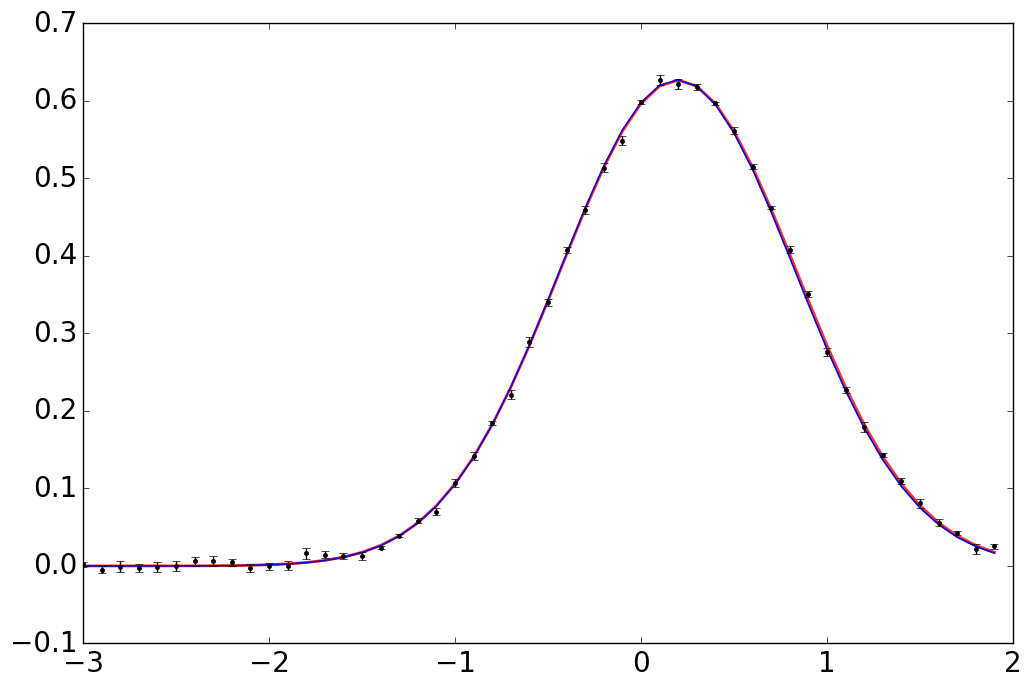

In [79]:
fig, ax =  plt.subplots()
ax.plot(x,myDoubleGaussianFunc(x,params[0],params[1],params[2],params[3]), color="k", alpha=0.8)
ax.plot(x, gauss(x,m_true,sigma_true), color="r", lw=2, alpha=0.8)
ax.plot(x,params[0]*gauss(x,params[2],params[1]))
ax.errorbar(x, y, yerr=yerr, fmt=".k")
fig.set_size_inches(12, 8)
print params

In [13]:
class Fit:
    def __init__(self,ndim,**var):
        self.range1 = var.get('range1',[0.,10.])
        self.range2 = var.get('range2',[0.,10.])
        self.range3 = var.get('range3',[0.,10.])
        self.range4 = var.get('range4',[0.,10.])
        self.ndim = ndim
        if self.ndim == 1:
            self.pos_min = np.array([0.0])
            self.pos_max = np.array([100.])
            self.condition = ()
        elif self.ndim == 2: 
            self.pos_min = np.array([-5.0,0.])
            self.pos_max = np.array([5.0,10.])
        elif self.ndim == 3: 
            self.pos_min = np.array([-20.0,0.,-2.])
            self.pos_max = np.array([20.0,600.,2.])
        elif self.ndim == 4: 
            self.pos_min = np.array([.0,-300.,-2.,-300.])
            self.pos_max = np.array([1.,300.,2.,300])
        else:
            print "ERROR: ndim > 4 not supported"
            sys.exit()
            
    def bestfit(self,func,x,y):
        yerr = 0.002 + 0.005*np.random.rand(len(x))
        # Now, let's setup some parameters that define the MCMC
        self.nwalkers = 500

        # Initialize the chain
        # Choice 1: chain uniformly distributed in the range of the parameters
        
        self.psize = self.pos_max - self.pos_min
        self.pos = [self.pos_min + self.psize*np.random.rand(self.ndim) for i in range(self.nwalkers)]

        # As prior, we assume an 'uniform' prior (i.e. constant prob. density)
        if self.ndim==1:
            def lnprior(theta):
                v0 = theta
                if self.range1[0] < v0 < self.range1[1]: 
                    return 0.0
                return -np.inf
            
            def lnlike(theta, x, y, yerr):
                v0 = theta
                alpha = 1.
                model = func(x,v0)
                return -0.05*(np.sum( ((y-model)/yerr)**2. ))
            
        if self.ndim==2:
            def lnprior(theta):
                mu,v0 = theta
                if self.range1[0] < mu < self.range1[1] and  \
                   self.range2[0] < v0 < self.range2[1]:
                    return 0.0
                return -np.inf
            
            def lnlike(theta, x, y, yerr):
                mu, v0 = theta
                alpha = 1.
                model = func(x,mu,v0)
                return -0.05*(np.sum( ((y-model)/yerr)**2. ))
            
        if self.ndim==3:
            def lnprior(theta):
                mu,v0,alpha = theta
                if self.range1[0] < mu < self.range1[1] and  \
                    self.range2[0] < v0 < self.range2[1] and  \
                     self.range3[0] < alpha < self.range3[1]:
                            return 0.0
                return -np.inf
            
            def lnlike(theta, x, y, yerr):
                mu, v0, alpha = theta
                alpha = 1.
                model = func(x,mu,v0, alpha)
                return -0.05*(np.sum( ((y-model)/yerr)**2. ))
            
        if self.ndim==4:
            def lnprior(theta):
                f,mu,v0,alpha = theta
                if self.range1[0] < f < self.range1[1] and  \
                    self.range2[0] < mu < self.range2[1] and  \
                     self.range3[0] < v0 < self.range3[1] and \
                        self.range4[0] < alpha < self.range4[1]:
                            return 0.0
                return -np.inf
           
            def lnlike(theta, x, y, yerr):
                frac,v01, mu, v02 = theta
                alpha = 1.
                model = func(x,frac,v01,mu,v02)
                return -0.05*(np.sum( ((y-model)/yerr)**2. ))
                
        # As likelihood, we assume the chi-square. Note: we do not even need to normalize it.
        

        def lnprob(theta, x, y, yerr):
            lp = lnprior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + lnlike(theta, x, y, yerr)
        print self.ndim
        sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim,
                                lnprob, args=(x, y, yerr))
        self.pos, self.prob, self.state  = sampler.run_mcmc(self.pos, 1000)
        self.samples = sampler.flatchain
        self.samples.shape
        self.sam=self.samples[-100:]
        if self.ndim==1:
            self.expected = np.array([func(x,i[0]) for i in self.sam ])
        if self.ndim==2:
            self.expected = np.array([func(x,i[0],i[1]) for i in self.sam ])
        if self.ndim==3:
            self.expected = np.array([func(x,i[0],i[1],i[2]) for i in self.sam ])
        if self.ndim==4:
            self.expected = np.array([func(x,i[0],i[1],i[2],i[3]) for i in self.sam ])
        self.observed = np.array([y for i in self.sam])
        self.chi_tmp = ((self.observed-self.expected)**2)/self.expected
        self.chi2 = [np.sum(i) for i in self.chi_tmp]
        self.params = self.sam[np.where(self.chi2==np.min(self.chi2))[0][0]]
        return self.params, np.min(self.chi2)
    

In [11]:
def myGaussian(x,mu,v0):
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myDoubleGaussianFunc(x,frac,v01,mu2,v02):
    return frac*myGaussian(x,mu2,v01)+(1-frac)*myGaussian(x,0,v02)

def myChi2(obs,exp,dof):
    return np.sum((obs-exp)**2/exp/dof,dtype=np.float64)

def myGenGaussian(x,mu,v0,alpha):
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myGenMaxwellian(x,v0,alpha):
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def myMaxwellian(x,v0):
    alpha = 1.
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def maosDistribution(x,v0,p):
    v_esc =541.
    term = ((v_esc**2) - (x**2))**p
    if x < v_esc and x > 0: 
        return (x**2) * np.exp(-x/v0) * term
    else:
        return 0

In [28]:
dg = Fit(2,range1=[-.5,.5], range2=[0.,5])
dg.bestfit(myGaussian,x,y)

2


(array([ 0.02137096,  1.99753041]), 0.010636515236932329)

In [12]:
tg = Fit(3)
tg.bestfit(myGenGaussian,x,y)

3


/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: RuntimeWarning: overflow encountered in divide


(array([  14.77120044,  171.61958893,   -1.38051088]), inf)

In [52]:
tg = Fit(2)
paramso = tg.bestfit(myGaussian,x,y)
print paramso

2
(array([ 0.20226959,  0.90583322]), 92.432116824513713)


-3.0


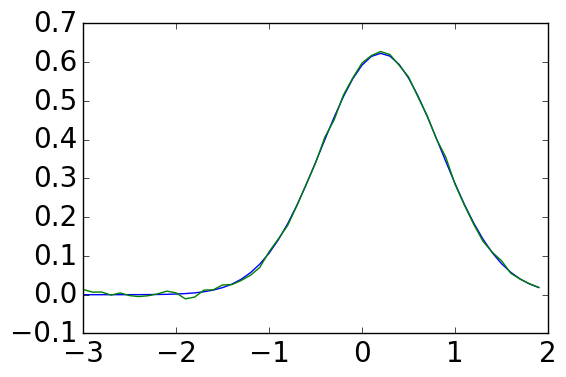

In [53]:
print np.min(x)
fig,ax = plt.subplots()
ax.plot(x,myGaussian(x,paramso[0][0],paramso[0][1]))
ax.plot(x,y)